# Model: XGBoost

### Importing Libraries

In [1]:
import _pickle as pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

### Loading in Data

In [2]:
df = pd.read_excel('../top10_corr_features.xlsx')
df = df.drop(df.columns[0], axis = 1)

### Scaling the Data

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_df = df.drop(["Decision"], 1)

scaled_df = pd.DataFrame(scaler.fit_transform(features_df), 
                               index=features_df.index, 
                               columns=features_df.columns)

df = scaled_df.join(df.Decision)

### Splitting the Data

In [4]:
X = df.drop(["Decision"], 1)
y = df.Decision

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Helper Functions

#### Function for plotting confusion matrix

In [5]:
def plot_confusion_matrix(y_true, y_pred, labels=["Sell", "Buy", "Hold"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

## Modeling
The preferred evaluation metric used will be __Precision__ for each class.  They will be optimized using the __F1 Score-Macro-Average__ to balance the Precision and Recall.  This is done because we want to not only be correct when predicting but also make a decent amount of predictions for each class.  Classes such as 'Buy' and 'Sell' are more important than 'Hold'.

### Fitting and Training

In [8]:
# Preventing error from occuring: XGBoost causes kernel to die.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost as xgb

In [9]:
# Instatiating the model classifier
clf = xgb.XGBClassifier()

# Fitting to the Data
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Printing out Evaluation Metrics

In [10]:
# Classifier predictions
pred = clf.predict(X_test)

#Printing out results
report = classification_report(y_test, pred, target_names=['Sell', 'Buy', 'Hold'])
print(report)

              precision    recall  f1-score   support

        Sell       0.29      0.22      0.25         9
         Buy       0.22      0.40      0.29         5
        Hold       0.00      0.00      0.00         3

    accuracy                           0.24        17
   macro avg       0.17      0.21      0.18        17
weighted avg       0.22      0.24      0.22        17



### Confusion Matrix

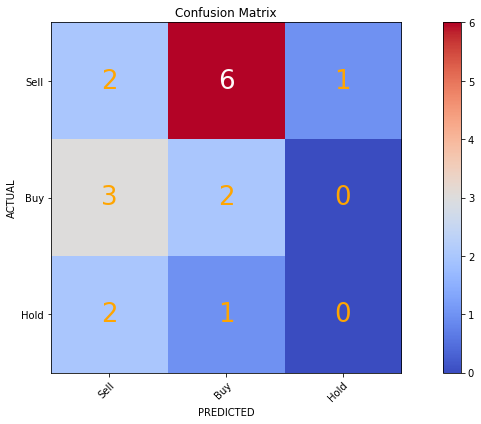

In [11]:
plot_confusion_matrix(y_test, pred, title="Confusion Matrix")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

## Tuning Model Parameters

In [12]:
from sklearn.model_selection import GridSearchCV

### Parameters

In [13]:
# Parameters to tune
params = {"booster": ["gbtree", "gblinear", 'dart'],
          "eta": [.1, .5, .9],
          "gamma": [0, 1, 3],
          "n_estimators": [50, 100, 200],
          "max_depth": [1, 3, 6],
          "grow_policy": ['depthwise', 'lossguide']}

In [14]:
search = GridSearchCV(clf, params, cv=3, return_train_score=True, verbose=5, scoring='f1_macro')

search.fit(X,y)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.863, test=0.190), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.798, test=0.418), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.816, test=0.344), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=(train=0.898, test=0.258), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=(train=0.927, test=0.364), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=(train=0.961, test=0.264), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=(train=1.000, test=0.364), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=(train=1.000, test=0.333), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=50, score=(train=1.000, test=0.245), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_

C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=1.000, test=0.208), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=1.000, test=0.294), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=1.000, test=0.443), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=1.000, test=0.264), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_

[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=1.000, test=0.484), total=   0.2s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=1.000, test=0.402), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.533, test=0.190), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.650, test=0.312), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_de

[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.650, test=0.312), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.513, test=0.234), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.845, test=0.190), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.928, test=0.325), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_de

[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.467, test=0.212), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.201, test=0.208), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.455, test=0.269), total=   0.1s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.467, test=0.212), total=   0.0s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=depthwise, max_

[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.467, test=0.212), total=   0.4s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.201, test=0.208), total=   0.2s
[CV] booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.455, test=0.269), total=   0.2s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.863, test=0.190), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=depthwise, max_

[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100, score=(train=0.913, test=0.328), total=   0.0s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.961, test=0.264), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=1.000, test=0.364), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=1.000, test=0.333), total=   0.2s
[CV] booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=0, grow_policy=lossguide, ma

[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.845, test=0.190), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.928, test=0.325), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.799, test=0.208), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.898, test=0.217), total=   0.0s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=depthwise, max_

[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.898, test=0.217), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.928, test=0.365), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.833, test=0.208), total=   0.2s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.467, test=0.212), total=   0.0s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=depthwise, max_

[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.467, test=0.212), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.201, test=0.208), total=   0.1s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.205, test=0.200), total=   0.0s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.467, test=0.212), total=   0.0s
[CV] booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.5, gamma=3, grow_policy=lossguide, max_

[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=1.000, test=0.208), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=1.000, test=0.294), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=1.000, test=0.443), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=1.000, test=0.264), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=depthwise, max_

[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=(train=1.000, test=0.473), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=1.000, test=0.178), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=1.000, test=0.484), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=1.000, test=0.402), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, ma

[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100, score=(train=0.513, test=0.234), total=   0.0s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.533, test=0.190), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.650, test=0.312), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.513, test=0.234), total=   0.0s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, ma

[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.467, test=0.212), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.201, test=0.208), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.455, test=0.269), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.467, test=0.212), total=   0.3s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=depthwise, max_

[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.467, test=0.212), total=   0.1s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.201, test=0.208), total=   0.2s
[CV] booster=gbtree, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.455, test=0.269), total=   0.2s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwi

[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_po

[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=

[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=

[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=gblinear, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=100, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.1, gamma=3, grow_policy=l

[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy

[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_poli

[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=gblinear, eta=0.5, gamma=1, grow_policy=

[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.5, gamma=3, grow_policy

[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_po

[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_poli

[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=100, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_po

[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=50, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=

[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=200, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=(train=0.376, test=0.233), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=(train=0.404, test=0.262), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=50, score=(train=0.354, test=0.253), total=   0.0s
[CV] booster=gblinear, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gblinear, eta=0.9, gamma=3, grow_policy=

[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=200, score=(train=1.000, test=0.402), total=   0.2s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=(train=0.863, test=0.190), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=(train=0.798, test=0.418), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=(train=0.816, test=0.344), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators

[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=200, score=(train=0.513, test=0.234), total=   0.1s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=(train=0.845, test=0.190), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=(train=0.928, test=0.325), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=(train=0.893, test=0.208), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=

[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=200, score=(train=0.799, test=0.208), total=   0.1s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=(train=0.898, test=0.217), total=   0.1s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=(train=0.928, test=0.365), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=(train=0.965, test=0.208), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators

[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=200, score=(train=0.455, test=0.269), total=   0.3s
[CV] booster=dart, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=50, score=(train=0.467, test=0.212), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=50, score=(train=0.201, test=0.208), total=   0.1s
[CV] booster=dart, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=50, score=(train=0.205, test=0.200), total=   0.0s
[CV] booster=dart, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=3, grow_policy=lossguide, max_depth=1, n_estimators

[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=50, score=(train=1.000, test=0.429), total=   0.0s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=(train=1.000, test=0.252), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=(train=1.000, test=0.294), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=(train=1.000, test=0.473), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=depthwise, max_depth=3, n_estim

[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=(train=1.000, test=0.268), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=(train=1.000, test=0.473), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=1.000, test=0.178), total=   0.2s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=1.000, test=0.484), total=   0.2s
[CV] booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=0, grow_policy=lossguide, max_depth=6, n_esti

[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.533, test=0.190), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.650, test=0.312), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=0.513, test=0.234), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.845, test=0.190), total=   0.0s
[CV] booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=1, grow_policy=lossguide, max_depth=3, n_estimat

[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.467, test=0.212), total=   0.2s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.201, test=0.208), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.455, test=0.269), total=   0.1s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.467, test=0.212), total=   0.0s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=depthwise, max_depth=6, n_estimat

[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.201, test=0.208), total=   0.2s
[CV] booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.5, gamma=3, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.455, test=0.269), total=   0.2s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.863, test=0.190), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.798, test=0.418), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimator

[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=1.000, test=0.364), total=   0.1s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=(train=1.000, test=0.333), total=   0.1s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=1.000, test=0.245), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=1.000, test=0.231), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimator

[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.928, test=0.325), total=   0.1s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=(train=0.799, test=0.208), total=   0.1s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.898, test=0.217), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=(train=0.928, test=0.365), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimator

[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=(train=0.833, test=0.208), total=   0.2s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.467, test=0.212), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.201, test=0.208), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=50, score=(train=0.205, test=0.200), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=depthwise, max_depth=1, n_estimators

[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.201, test=0.208), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=50, score=(train=0.455, test=0.269), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=100, score=(train=0.467, test=0.212), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimators=100, score=(train=0.201, test=0.208), total=   0.0s
[CV] booster=dart, eta=0.9, gamma=3, grow_policy=lossguide, max_depth=3, n_estimator

[Parallel(n_jobs=1)]: Done 1458 out of 1458 | elapsed:  1.5min finished
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_la...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'eta': [0.1, 0.5, 0.9], 'gamma': [0, 1, 3],
                         'grow_poli

### Tuned Results

In [15]:
print("Mean Training Score:", np.mean(search.cv_results_['mean_train_score']))
print("Mean Testing Score:", search.score(X, y))
print("\nBest Parameter Found:")
search.best_params_

Mean Training Score: 0.5920878583129973
Mean Testing Score: 1.0

Best Parameter Found:


{'booster': 'gbtree',
 'eta': 0.1,
 'gamma': 0,
 'grow_policy': 'depthwise',
 'max_depth': 6,
 'n_estimators': 200}

### Model with the Best Parameters

In [16]:
search_clf = search.best_estimator_

search_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              grow_policy='depthwise', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

#### Results from Optimum Parameters

In [17]:
# Classifier predictions
s_pred = search_clf.predict(X_test)

#Printing out results
report = classification_report(y_test, s_pred, target_names=['Sell', 'Buy', 'Hold'])
print(report)

              precision    recall  f1-score   support

        Sell       0.29      0.22      0.25         9
         Buy       0.20      0.40      0.27         5
        Hold       0.00      0.00      0.00         3

    accuracy                           0.24        17
   macro avg       0.16      0.21      0.17        17
weighted avg       0.21      0.24      0.21        17



C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Confusion Matrix for Optimum Parameters

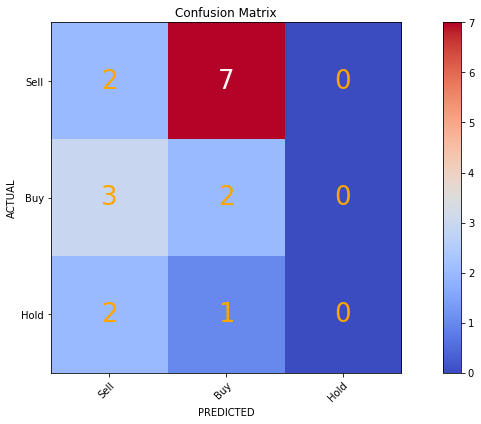

In [18]:
plot_confusion_matrix(y_test, s_pred, title="Confusion Matrix")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()